# Electrical Distribution Network Energy Consumption Forecasting based upon Victorian MRIM Meter Data

In this notebook, the Energy Consumption from CitiPower will be forecasted based on Historical Data using SARIMA and SARIMAX. 

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Reading into the Data

In [2]:
data = pd.read_csv('citipower.csv')

# EDA

In [3]:
data.head()

,SETTD,DAILYT
0,2014-04-01,6363749.701
1,2014-04-02,5630825.535
2,2014-04-03,5173891.385
3,2014-04-04,5044050.180
4,2014-04-05,4383318.300


In [4]:
data.columns

Index(['SETTD', 'DAILYT'], dtype='object')

In [5]:
data.dtypes

SETTD      object
DAILYT    float64
dtype: object

# Setting Date as its index

In [6]:
data['SETTD'] = pd.to_datetime(data['SETTD'], dayfirst = True)

In [7]:
data = data.set_index('SETTD')

In [8]:
sum(data.isnull().sum())

0

Text(0, 0.5, 'Energy Consumption (kWh)')

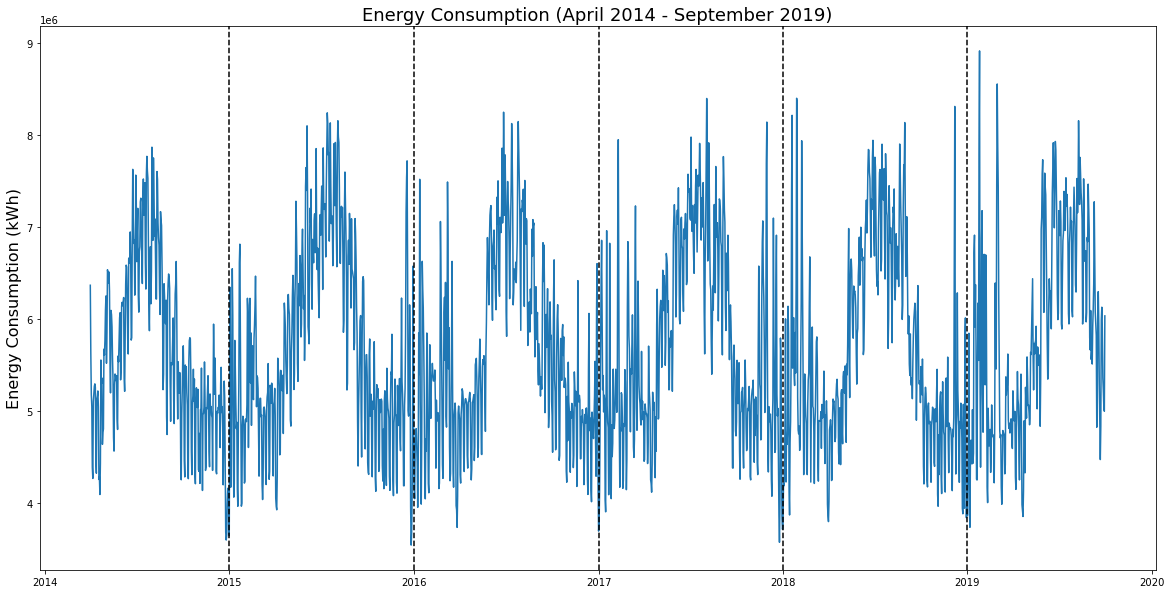

In [9]:
plt.figure(figsize = (20,10))
plt.plot(data)
for year in range(2015,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')
plt.title('Energy Consumption (April 2014 - September 2019)', fontsize = 18)
plt.ylabel('Energy Consumption (kWh)', fontsize = 16)

# Seasonal Decomposition

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

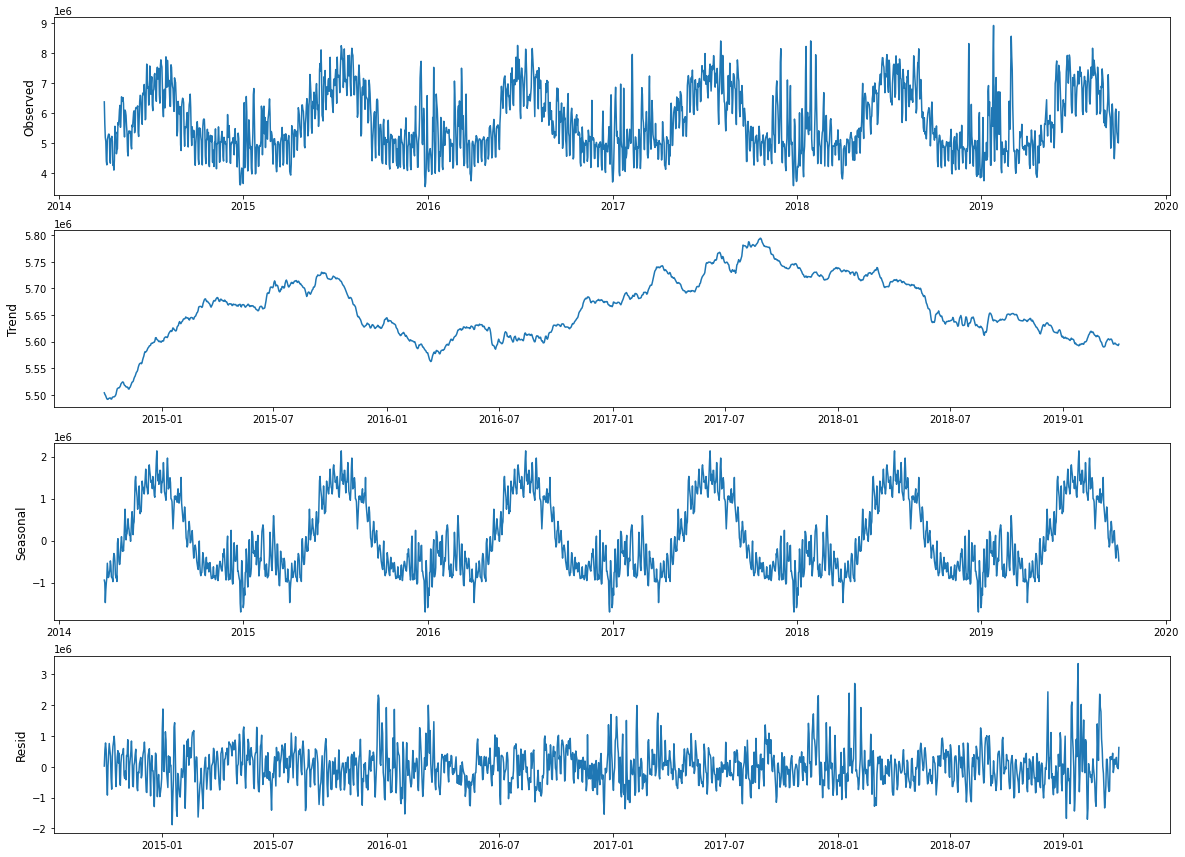

In [11]:
decomp = seasonal_decompose(data, period = 365)
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

plt.figure(figsize = (20,15))
plt.subplot(411)
plt.plot(data)
plt.ylabel('Observed', fontsize = 12)
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend', fontsize = 12)
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal', fontsize = 12)
plt.subplot(414)
plt.plot(resid)
plt.ylabel('Resid', fontsize = 12)
plt.show()

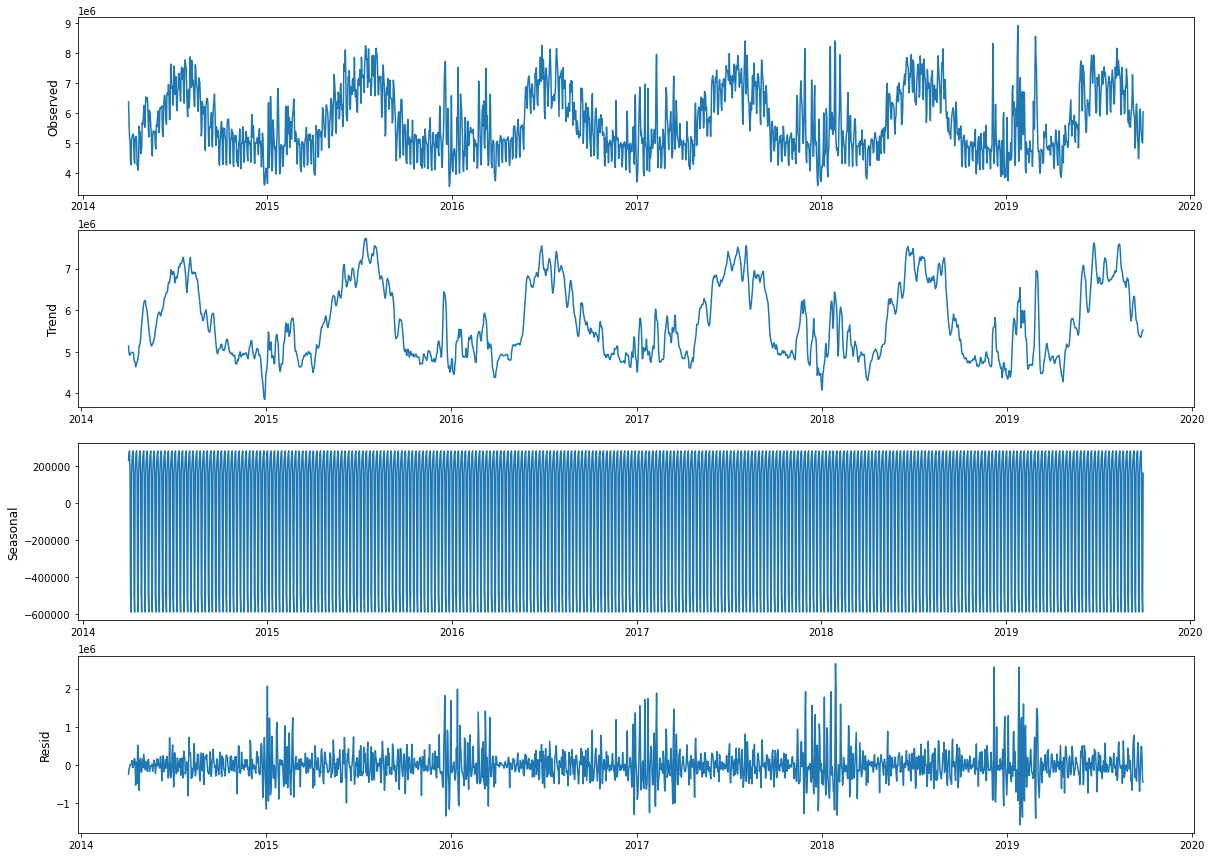

In [12]:
decomp = seasonal_decompose(data, period = 7)
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

plt.figure(figsize = (20,15))
plt.subplot(411)
plt.plot(data)
plt.ylabel('Observed', fontsize = 12)
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend', fontsize = 12)
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal', fontsize = 12)
plt.subplot(414)
plt.plot(resid)
plt.ylabel('Resid', fontsize = 12)
plt.show()

# Split Train/Test

The objective is to predict the energy consumption in 2019.

In [13]:
train = data[data.index.year != 2019]
test = data[data.index.year == 2019]

# Checking Stationarity

## Dickey-Fuller Test

The Dickey-Fuller test is a type of hypothesis testing to determine whether the df is either stationary or non-stationary. <br>
- If the p_value is less than 0.5, reject the null hypothesis and the df is stationary.
- If the p_value is more than 0.5, accept the null hypothesis and the df is non-stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.200387
p-value: 0.019962
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [16]:
# Differential of a period of 1
diff = train.diff().dropna()
# Differential of a period of 365 (Yearly Seasonality)
diff_365 = train.diff(periods = 365).dropna()
# Differential of a period of 7 (Weekly Seasonality)
diff_7 = train.diff(periods = 7).dropna()


In [17]:
result = adfuller(diff_365)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.278127
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [18]:
result = adfuller(diff_7)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.364039
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


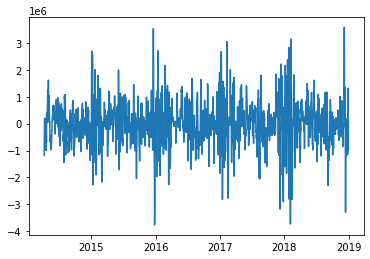

In [19]:
plt.plot(diff_7)

Based on the plot, the data is stationary. Therefore, no differential is needed. 

d = 0 for ARIMA parameter

# SARIMA model

The performance of the ARIMA model will be used as a baseline model.

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 0, 'Lag (Days)')

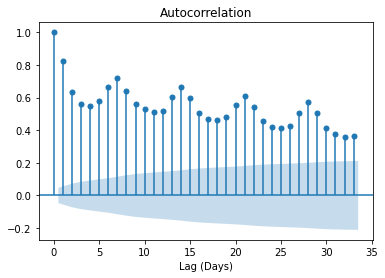

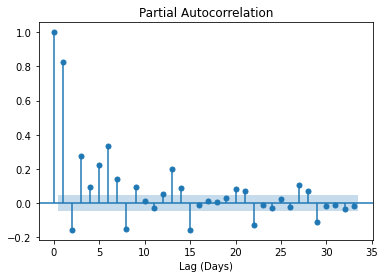

In [21]:
# Plotting autocorrelation function
plot_acf(train)
plt.xlabel('Lag (Days)')
plot_pacf(train)
plt.xlabel('Lag (Days)')

ARIMA order is still (1,0,0)

Text(0.5, 0, 'Lag (Days)')

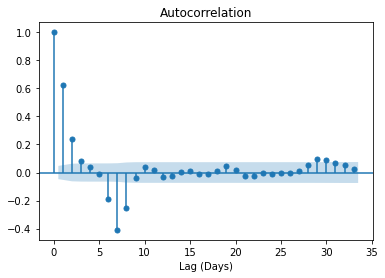

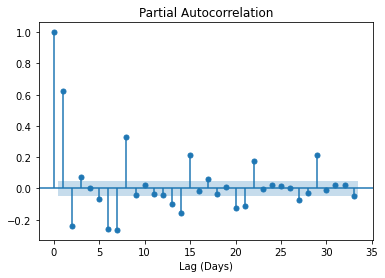

In [22]:
plot_acf(diff_7)
plt.xlabel('Lag (Days)')
plot_pacf(diff_7)
plt.xlabel('Lag (Days)')

Best guess for the seasonal order (0,1,1,7)

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [26]:
model_trial = SARIMAX(train, order = (1,0,0), seasonal_order = (0,1,1,7), 
                     enforce_stationary = False, 
                     enforce_invertibility = False).fit()

In [27]:
predict1 = model_trial.predict(pd.to_datetime('2019-01-01'),pd.to_datetime('2019-09-30'))

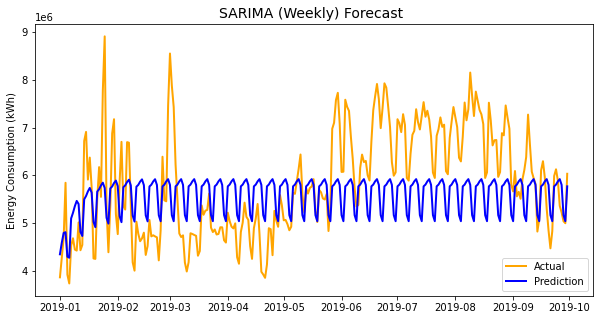

In [28]:
plt.figure(figsize=(10,5))
# plt.fill_between(test.index, predict[-1][:,1], predict[-1][:,0], 
#                  alpha = 0.25, color = 'black')
plt.plot(test, linewidth = 2, label = 'Actual', color = 'orange')
plt.plot(predict1, linewidth = 2, label = 'Prediction',  color = 'b')
plt.title('SARIMA (Weekly) Forecast ', fontsize = 14)
plt.legend(loc = 'lower right')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

## Model below uses 365. WARNING: High Computation Requirement

In [29]:
# model_best = SARIMAX(train, order = (1,0,0), seasonal_order = (0,1,0,365), 
#                      enforce_stationary = False, 
#                      enforce_invertibility = False, freq = 'D').fit()

In [30]:
# predict_365 = model_best.predict('2019-01-01', '2019-09-30')
# predict_365.to_csv('SARIMA_365_prediction.csv')

In [31]:
# plt.figure(figsize = (20,10))
# plt.plot(predict_365, linewidth = 2)
# plt.plot(test, linewidth = 2)
# plt.title('SARIMA model with period = 365', fontsize = 16)
# plt.ylabel('Power Consumption (kWh)', fontsize = 14)
# plt.legend(['Prediction', 'Actual'], fontsize = 'x-large')
# plt.savefig('SARIMA_365.png')

In [32]:
# To avoid running the 365 interval again, the results was collected into a csv file
predict_365 = pd.read_csv('SARIMA_365_prediction.csv')
predict_365.columns = ['date', 'predict']
predict_365['date'] = pd.to_datetime(predict_365['date'])
predict_365.set_index('date', inplace = True)
predict_365.head()

,predict
date,
2019-01-01,3.974896e+06
2019-01-02,4.323976e+06
2019-01-03,4.246831e+06
2019-01-04,4.383170e+06
2019-01-05,4.879140e+06


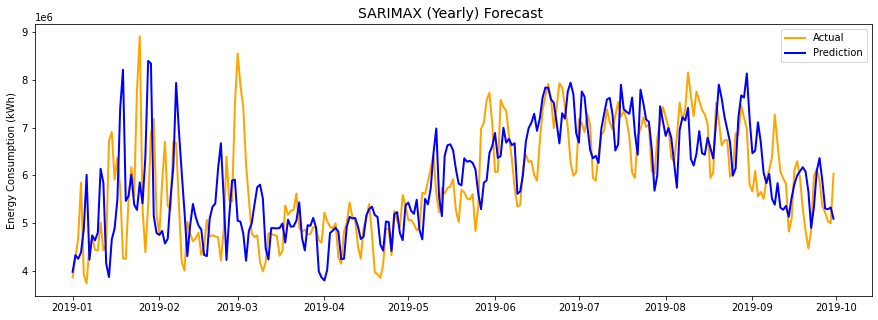

In [33]:
plt.figure(figsize = (15,5))
plt.plot(test, linewidth = 2, label = 'Actual', color = 'orange')
plt.plot(predict_365, linewidth = 2, label = 'Prediction',  color = 'b')
plt.title('SARIMAX (Yearly) Forecast ', fontsize = 14)
plt.ylabel('Energy Consumption (kWh)')
plt.legend(loc = 'upper right')

plt.show()

Limitations of SARIMA: 
- SARIMA can model only a single seasonal effect
- Season effect should not be too long

## SARIMAX 
- Includes exogenous variables
    - External factors (Weather / **Additional Seasonal Component**)

In [34]:
# prepare Fourier terms
data['sin365'] = np.sin(2 * np.pi * data.index.dayofyear / 365.25)
data['cos365'] = np.cos(2 * np.pi * data.index.dayofyear / 365.25)
data['sin365_2'] = np.sin(4 * np.pi * data.index.dayofyear / 365.25)
data['cos365_2'] = np.cos(4 * np.pi * data.index.dayofyear / 365.25)
# data['sin365_3'] = np.sin(6 * np.pi * data.index.dayofyear / 365.25)
# data['cos365_3'] = np.cos(6 * np.pi * data.index.dayofyear / 365.25)
# data.drop(['cos365_3', 'sin365_3'], axis = 1, inplace = True)
# data = data.drop(columns=['SETTD'])
# data_to_train = data.iloc[:(len(data)-273)]
# data_to_test = data.iloc[(len(data)-273):]

In [35]:
data

,DAILYT,sin365,cos365,sin365_2,cos365_2
SETTD,,,,,
2014-04-01,6363749.701,0.999986,0.005376,0.010751,-0.999942
2014-04-02,5630825.535,0.999930,-0.011826,-0.023651,-0.999720
2014-04-03,5173891.385,0.999579,-0.029025,-0.058026,-0.998315
2014-04-04,5044050.180,0.998932,-0.046215,-0.092331,-0.995728
2014-04-05,4383318.300,0.997989,-0.063391,-0.126528,-0.991963
...,...,...,...,...,...
2019-09-26,5357014.025,-0.996395,-0.084835,0.169058,-0.985606
2019-09-27,5219544.620,-0.997707,-0.067683,0.135055,-0.990838
2019-09-28,5036389.054,-0.998724,-0.050511,0.100892,-0.994897


In [36]:
train = data.iloc[:(len(data)-273)]['DAILYT']
test = data.iloc[(len(data)-273):]['DAILYT']
exog_train = data.drop(['DAILYT'], axis = 1)['2014-04-01':'2018-12-31']
exog_test = data.drop(['DAILYT'], axis = 1)['2019-01-01':]

In [37]:
model = SARIMAX(train, order = (1,0,0), seasonal_order = (0,1,1,7), 
                exog = exog_train, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D').fit()

In [38]:
predict2 = model.forecast(steps = 273, exog = exog_test)

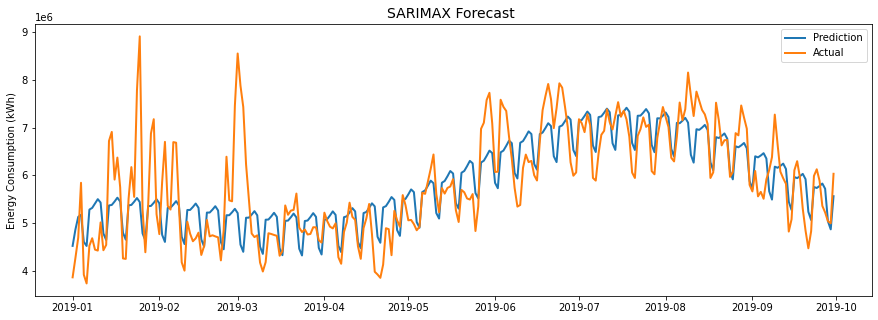

In [39]:
plt.figure(figsize = (15,5))
plt.plot(predict2, linewidth = 2)
plt.plot(test, linewidth = 2)
plt.title('SARIMAX Forecast ', fontsize = 14)
plt.legend(['Prediction', 'Actual'], loc = 'upper right')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Walk-Forward Validation

In [40]:
# walk-forward validation
history = [x for x in train]
exog_hist = exog_train.copy()
predictions = list()

for i in range(len(test)):
    # predict
    model = SARIMAX(history, order = (1,0,0), seasonal_order = (0,1,1,7), 
                exog = exog_hist, 
                enforce_stationary = False, 
                enforce_invertibility = False, 
                freq = 'D')
    model_fit = model.fit()
    yhat = model_fit.forecast(exog = exog_test.iloc[i,:]) #Forecasting the next step
    predictions.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)
    exog_hist = exog_hist.append(exog_test.iloc[i,:])

In [41]:
predictions_complete = pd.Series()
for i in predictions:
    predictions_complete = predictions_complete.append(i)

In [42]:
a = pd.DataFrame(test)
b = pd.DataFrame(predictions_complete)
b.set_index(test.index, inplace = True)
compare = pd.concat([a,b],axis = 1)
compare.columns = ['Actual', 'Predict']
compare.head()

,Actual,Predict
SETTD,,
2019-01-01,3858957.991,4.518188e+06
2019-01-02,4264155.819,4.415858e+06
2019-01-03,4690920.697,4.724773e+06
2019-01-04,5841792.852,4.877707e+06
2019-01-05,3913922.670,5.045530e+06


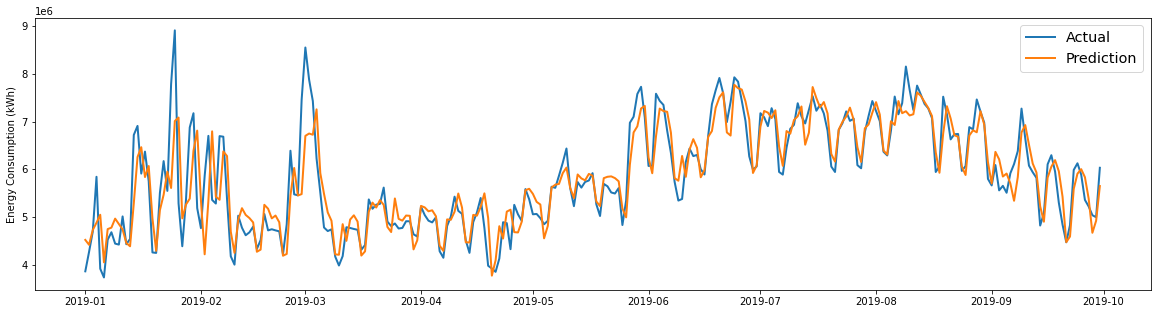

In [43]:
plt.figure(figsize = (20,5))
plt.plot(compare['Actual'], label = 'Actual', linewidth = 2)
plt.plot(compare['Predict'], label = 'Prediction', linewidth = 2)
plt.legend(fontsize = 'x-large')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Performance Evaluation

In [44]:
from sklearn.metrics import r2_score
#############################################
#         evaluation function by AMMAR      #
#############################################
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))

In [45]:
# regPrintErr(test.iloc[0].values, predict_arima_daily[0])

In [46]:
# regPrintErr(test.iloc[:31].values, predict_arima_monthly[0])

In [47]:
print('SARIMA: Weekly Seasonality')
regPrintErr(test, predict1)

SARIMA: Weekly Seasonality
R2 Score: 0.07795057842637909
MAPE: 14.92440112870043


In [48]:
print('SARIMA: Yearly Seasonality')
regPrintErr(test.values, predict_365['predict'])

SARIMA: Yearly Seasonality
R2 Score: 0.2484465626632537
MAPE: 12.154548077600207


In [49]:
print('SARIMAX: Includes Both Weekly and Yearly Seasonality')
regPrintErr(test, predict2)

SARIMAX: Includes Both Weekly and Yearly Seasonality
R2 Score: 0.5749968047542275
MAPE: 8.648514258380114


In [50]:
print('Walk-Forward Testing (SARIMAX)')
regPrintErr(compare['Actual'], compare['Predict'])

Walk-Forward Testing (SARIMAX)
R2 Score: 0.785567453176544
MAPE: 6.0652022050369885


The model where 2 seasonalities were modelled into SARIMAX performed the best.

The model evaluations are performed in 'Model Evaluation' notebook.

In [51]:
results = {'Actual': test.values, 'SARIMA (weekly)':predict1, 
         'SARIMA (Yearly)': predict_365['predict'], 'SARIMAX': predict2, 'SARIMAX (Walk-Forward)': compare['Predict']}

In [52]:
results_SARIMA = pd.DataFrame(results)

In [53]:
results_SARIMA.head()

,Actual,SARIMA (weekly),SARIMA (Yearly),SARIMAX,SARIMAX (Walk-Forward)
2019-01-01,3858957.991,4.341858e+06,3.974896e+06,4.518188e+06,4.518188e+06
2019-01-02,4264155.819,4.587022e+06,4.323976e+06,4.861791e+06,4.415858e+06
2019-01-03,4690920.697,4.789656e+06,4.246831e+06,5.126768e+06,4.724773e+06
2019-01-04,5841792.852,4.806033e+06,4.383170e+06,5.170638e+06,4.877707e+06
2019-01-05,3913922.670,4.292207e+06,4.879140e+06,4.601621e+06,5.045530e+06


In [54]:
results_SARIMA.to_csv('results_SARIMA.csv')